In [5]:
import json

with open("../../data/llama-3_2-3b/mmlu/original.json") as file:
    original_data = json.load(file)

with open("../../data/llama-3_2-3b/mmlu/lexical/random.json") as file:
    random_data = json.load(file)

with open("../../data/llama-3_2-3b/mmlu/lexical/synonym.json") as file:
    synonym_data = json.load(file)

with open("../../data/llama-3_2-3b/mmlu/lexical/wrong_sense.json") as file:
    wrong_sense_data = json.load(file)

with open("../../data/llama-3_2-3b/mmlu/lexical/worst_sense.json") as file:
    worst_sense_data = json.load(file)

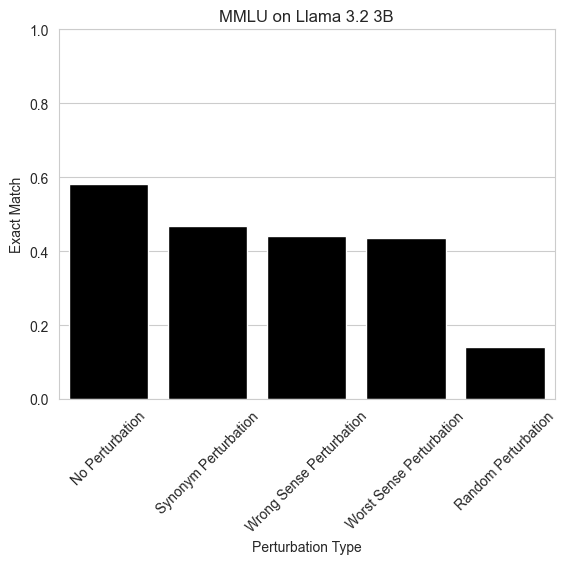

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

x_axis_labels = ["No Perturbation", "Synonym Perturbation", "Wrong Sense Perturbation", "Worst Sense Perturbation", "Random Perturbation"]
metrics = [
    original_data["metrics"]["exact_match"],
    synonym_data["metrics"]["exact_match"],
    wrong_sense_data["metrics"]["exact_match"],
    worst_sense_data["metrics"]["exact_match"],
    random_data["metrics"]["exact_match"]
]

barplot = sns.barplot(x=range(len(x_axis_labels)), y=metrics, color="black")
barplot.set_xticks(range(len(x_axis_labels)))
barplot.set_xticklabels(x_axis_labels, rotation=45)
plt.ylim(0, 1)
plt.xlabel("Perturbation Type")
plt.ylabel("Exact Match")
plt.title("MMLU on Llama 3.2 3B")
plt.show()

In [10]:
import pandas as pd

synonym_preds_df = pd.DataFrame.from_dict(synonym_data["predictions"])

with open("../../data/mmlu/lexical/synonym_perturbation.json") as file:
    synonym_data = json.load(file)

synonym_data_df = pd.DataFrame.from_dict(synonym_data["data"])

In [17]:
synonym_preds_df["question_metadata"] = synonym_data_df["question_metadata"]
synonym_preds_df["choice_metadata"] = synonym_data_df["choice_metadata"]
synonym_preds_df.head()

,dataset,question,answer,prediction,output,question_metadata,choice_metadata
0,abstract_algebra,Determine the level for the afforded field ext...,B,C,C,"{'n_synsets': [15, 0, 7, 0, 0, 43, 17, 12, 0, ...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'..."
1,abstract_algebra,"Allow P = (1, 2, 5, 4)(2, 3) in S_5 . Ascertai...",C,C,C,"{'n_synsets': [6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'..."
2,abstract_algebra,Discover all nothings in the shown finite fiel...,D,C,C,"{'n_synsets': [15, 0, 4, 0, 0, 5, 2, 17, 0, 0,...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'..."
3,abstract_algebra,Statement 1 | A constituent grouping of a non-...,B,C,C,"{'n_synsets': [7, 0, 0, 0, 7, 3, 0, 0, 0, 0, 0...","[{'n_synsets': [2, 0, 2], 'n_lemmas': [0, 0, 0..."
4,abstract_algebra,Determine the mathematical product of the affo...,B,C,C,"{'n_synsets': [15, 0, 6, 0, 0, 43, 1, 0, 0, 43...","[{'n_synsets': [0, 0, 0], 'n_lemmas': [0, 0, 0..."


In [19]:
def sum_changed_tokens(row):
    n_changed_in_question = row.question_metadata["n_changed_tokens"]
    n_changed_in_choices = sum(choice["n_changed_tokens"] for choice in row.choice_metadata)

    return n_changed_in_question + n_changed_in_choices

synonym_preds_df["n_changed_tokens"] = synonym_preds_df.apply(sum_changed_tokens, axis=1)
synonym_preds_df.n_changed_tokens.describe()

count    14042.000000
mean        20.936761
std         23.038635
min          0.000000
25%          7.000000
50%         13.000000
75%         24.000000
max        255.000000
Name: n_changed_tokens, dtype: float64

In [21]:
def fraction_changed_tokens(row):
    n_changed_in_question = row.question_metadata["n_changed_tokens"]
    n_changed_in_choices = sum(choice["n_changed_tokens"] for choice in row.choice_metadata)

    n_content_in_question = row.question_metadata["n_content_tokens"]
    n_content_in_choices = sum(choice["n_content_tokens"] for choice in row.choice_metadata)

    if n_content_in_question + n_content_in_choices == 0:
        return 0

    return (n_changed_in_question + n_changed_in_choices) / (n_content_in_question + n_content_in_choices)


synonym_preds_df["fraction_changed_tokens"] = synonym_preds_df.apply(fraction_changed_tokens, axis=1)
synonym_preds_df.fraction_changed_tokens.describe()

count    14042.000000
mean         0.547485
std          0.156314
min          0.000000
25%          0.447368
50%          0.560000
75%          0.650000
max          1.000000
Name: fraction_changed_tokens, dtype: float64

In [23]:
def correct_prediction(row):
    return row.prediction == row.answer

synonym_preds_df["correct_prediction"] = synonym_preds_df.apply(correct_prediction, axis=1)
synonym_preds_df.correct_prediction.describe()

count     14042
unique        2
top       False
freq       7480
Name: correct_prediction, dtype: object

/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_63959/1044055334.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy = synonym_preds_df.groupby('token_bin')['correct_prediction'].mean().reset_index()


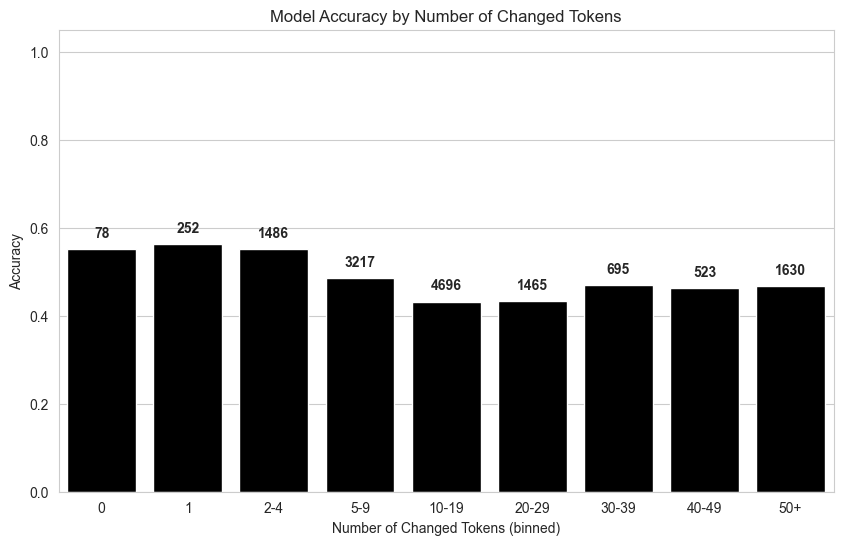

In [24]:
import numpy as np

# 1. Create bins for n_changed_tokens
bins = [0, 1, 2, 5, 10, 20, 30, 40, 50, np.inf]
labels = ['0', '1', '2-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50+']
synonym_preds_df['token_bin'] = pd.cut(
    synonym_preds_df['n_changed_tokens'],
    bins=bins,
    labels=labels,
    right=False
)

# 2. Calculate accuracy per bin
bin_accuracy = synonym_preds_df.groupby('token_bin')['correct_prediction'].mean().reset_index()
# Calculate counts per bin
bin_counts = synonym_preds_df['token_bin'].value_counts().reindex(labels)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='token_bin', y='correct_prediction', data=bin_accuracy, color='black')

# Annotate counts on top of bars
for i, count in enumerate(bin_counts):
    ax.text(i, bin_accuracy['correct_prediction'][i] + 0.02, str(int(count)), 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Number of Changed Tokens (binned)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Number of Changed Tokens')
plt.ylim(0, 1.05)
plt.show()

/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_63959/988019953.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy = synonym_preds_df.groupby('fraction_bin')['correct_prediction'].mean().reset_index()


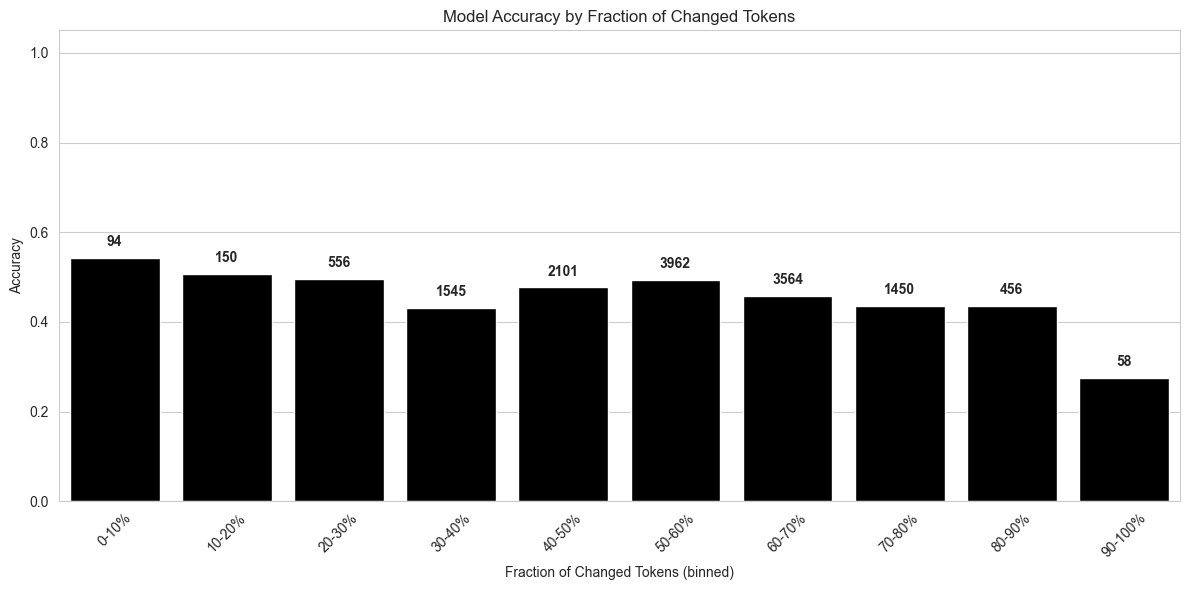

In [25]:
# Create bins for fraction_changed_tokens
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
synonym_preds_df['fraction_bin'] = pd.cut(
    synonym_preds_df['fraction_changed_tokens'],
    bins=bins,
    labels=labels,
    right=False
)

# Calculate accuracy per bin
bin_accuracy = synonym_preds_df.groupby('fraction_bin')['correct_prediction'].mean().reset_index()
# Calculate counts per bin
bin_counts = synonym_preds_df['fraction_bin'].value_counts().reindex(labels)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='fraction_bin', y='correct_prediction', data=bin_accuracy, color='black')

# Annotate counts on top of bars
for i, count in enumerate(bin_counts):
    ax.text(i, bin_accuracy['correct_prediction'][i] + 0.02, str(int(count)), 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Fraction of Changed Tokens (binned)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Fraction of Changed Tokens')
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
original_preds_df = pd.DataFrame.from_dict(original_data["predictions"])
synonym_preds_df["original_prediction"] = original_preds_df["prediction"]
synonym_preds_df["correct_original_prediction"] = synonym_preds_df["original_prediction"] == synonym_preds_df["answer"]
synonym_preds_df.head()

,dataset,question,answer,prediction,output,question_metadata,choice_metadata,n_changed_tokens,fraction_changed_tokens,token_bin,correct_prediction,fraction_bin,original_prediction,correct_original_prediction
0,abstract_algebra,Determine the level for the afforded field ext...,B,C,C,"{'n_synsets': [15, 0, 7, 0, 0, 43, 17, 12, 0, ...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'...",3,0.600000,2-4,False,60-70%,C,False
1,abstract_algebra,"Allow P = (1, 2, 5, 4)(2, 3) in S_5 . Ascertai...",C,C,C,"{'n_synsets': [6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'...",4,1.000000,2-4,True,NaN,C,True
2,abstract_algebra,Discover all nothings in the shown finite fiel...,D,C,C,"{'n_synsets': [15, 0, 4, 0, 0, 5, 2, 17, 0, 0,...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'...",4,0.363636,2-4,False,30-40%,D,True
3,abstract_algebra,Statement 1 | A constituent grouping of a non-...,B,C,C,"{'n_synsets': [7, 0, 0, 0, 7, 3, 0, 0, 0, 0, 0...","[{'n_synsets': [2, 0, 2], 'n_lemmas': [0, 0, 0...",4,0.142857,2-4,False,10-20%,C,False
4,abstract_algebra,Determine the mathematical product of the affo...,B,C,C,"{'n_synsets': [15, 0, 6, 0, 0, 43, 1, 0, 0, 43...","[{'n_synsets': [0, 0, 0], 'n_lemmas': [0, 0, 0...",7,0.636364,5-9,False,60-70%,B,True


/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_63959/921493911.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy_original = synonym_preds_df.groupby('fraction_bin')['correct_original_prediction'].mean().reset_index()
/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_63959/921493911.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy_perturbed = synonym_preds_df.groupby('fraction_bin')['correct_prediction'].mean().reset_index()


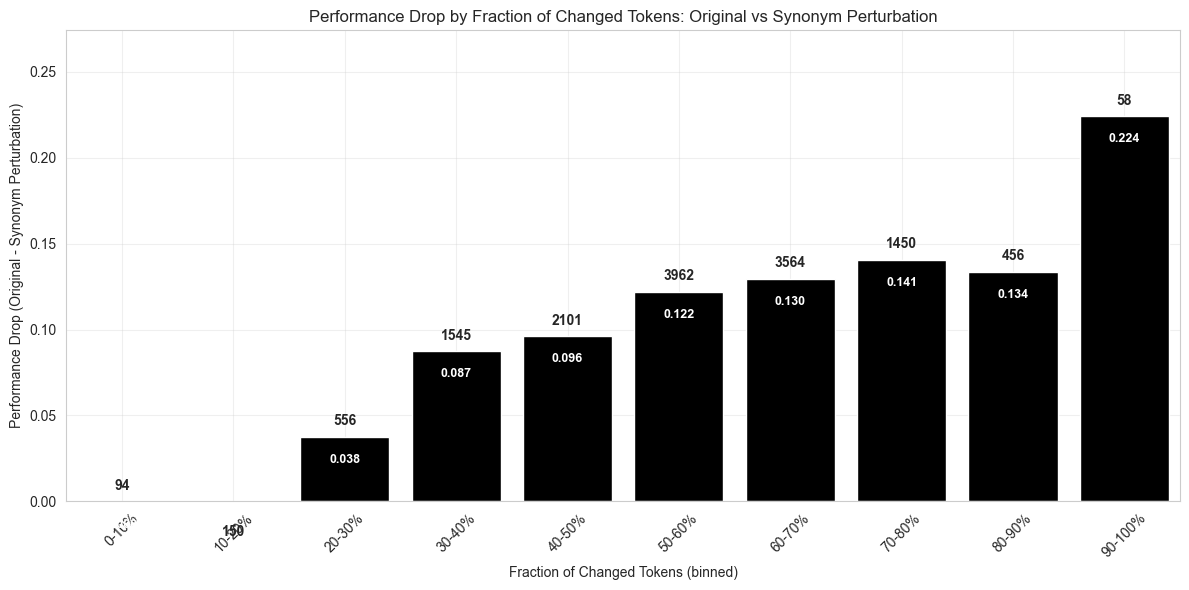

=== PERFORMANCE DROP ANALYSIS ===
Overall performance drop: 0.094
Maximum performance drop: 0.224 (in 90-100% range)
Minimum performance drop: -0.027 (in 10-20% range)
Standard deviation: 0.074


In [35]:
# Create bins for fraction_changed_tokens (replicating the existing approach)
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Calculate accuracy per bin for both original and perturbed data
bin_accuracy_original = synonym_preds_df.groupby('fraction_bin')['correct_original_prediction'].mean().reset_index()
bin_accuracy_perturbed = synonym_preds_df.groupby('fraction_bin')['correct_prediction'].mean().reset_index()

# Calculate performance drop (original - perturbed) for each bin
bin_accuracy_original['performance_drop'] = bin_accuracy_original['correct_original_prediction'] - bin_accuracy_perturbed['correct_prediction']

# Calculate counts per bin
bin_counts = synonym_preds_df['fraction_bin'].value_counts().reindex(labels)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='fraction_bin', y='performance_drop', data=bin_accuracy_original, color='black')

# Annotate counts on top of bars
for i, count in enumerate(bin_counts):
    ax.text(i, bin_accuracy_original['performance_drop'][i] + 0.005, str(int(count)), 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add performance drop values on bars
for i, drop in enumerate(bin_accuracy_original['performance_drop']):
    ax.text(i, drop - 0.01, f'{drop:.3f}', 
            ha='center', va='top', fontsize=9, fontweight='bold', color='white')

plt.xlabel('Fraction of Changed Tokens (binned)')
plt.ylabel('Performance Drop (Original - Synonym Perturbation)')
plt.title('Performance Drop by Fraction of Changed Tokens: Original vs Synonym Perturbation')
plt.ylim(0, max(bin_accuracy_original['performance_drop']) + 0.05)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("=== PERFORMANCE DROP ANALYSIS ===")
print(f"Overall performance drop: {bin_accuracy_original['performance_drop'].mean():.3f}")
print(f"Maximum performance drop: {bin_accuracy_original['performance_drop'].max():.3f} (in {labels[bin_accuracy_original['performance_drop'].idxmax()]} range)")
print(f"Minimum performance drop: {bin_accuracy_original['performance_drop'].min():.3f} (in {labels[bin_accuracy_original['performance_drop'].idxmin()]} range)")
print(f"Standard deviation: {bin_accuracy_original['performance_drop'].std():.3f}")


In [36]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
embedder = model.get_input_embeddings()
del model

/Users/bogdan/miniconda3/envs/thesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:52<00:00, 26.25s/it]


In [67]:
import torch
import torch.nn.functional as F

def mean_cosine_similarity(row):
    n_words = 0
    cosine_sum = 0
    for original, synonym in row["question_metadata"]["changes"]:
        if original == synonym:
            n_words += 1
            cosine_sum += 1
        else:
            original_input_ids = tokenizer(original, add_special_tokens=False, return_tensors="pt")["input_ids"]
            synonym_input_ids = tokenizer(synonym, add_special_tokens=False, return_tensors="pt")["input_ids"]
            
            with torch.no_grad():
                original_embeddings = embedder(original_input_ids).mean(dim=1).flatten()
                synonym_embeddings = embedder(synonym_input_ids).mean(dim=1).flatten()

                cosine = F.cosine_similarity(original_embeddings, synonym_embeddings, dim=0).item()
                cosine_sum += cosine
                n_words += 1

    for choice in row["choice_metadata"]:
        for original, synonym in choice["changes"]:
            if original == synonym:
                n_words += 1
                cosine_sum += 1
            else:
                original_input_ids = tokenizer(original, add_special_tokens=False, return_tensors="pt")["input_ids"]
                synonym_input_ids = tokenizer(synonym, add_special_tokens=False, return_tensors="pt")["input_ids"]
                
                with torch.no_grad():
                    original_embeddings = embedder(original_input_ids).mean(dim=1).flatten()
                    synonym_embeddings = embedder(synonym_input_ids).mean(dim=1).flatten()

                cosine = F.cosine_similarity(original_embeddings, synonym_embeddings, dim=0).item()
                cosine_sum += cosine
                n_words += 1

    return cosine_sum / n_words

In [68]:
synonym_preds_df["mean_cosine_similarity"] = synonym_preds_df.apply(mean_cosine_similarity, axis=1)
synonym_preds_df.mean_cosine_similarity.describe()

count    14042.000000
mean         0.813399
std          0.070940
min          0.434014
25%          0.768723
50%          0.811901
75%          0.862524
max          1.000000
Name: mean_cosine_similarity, dtype: float64

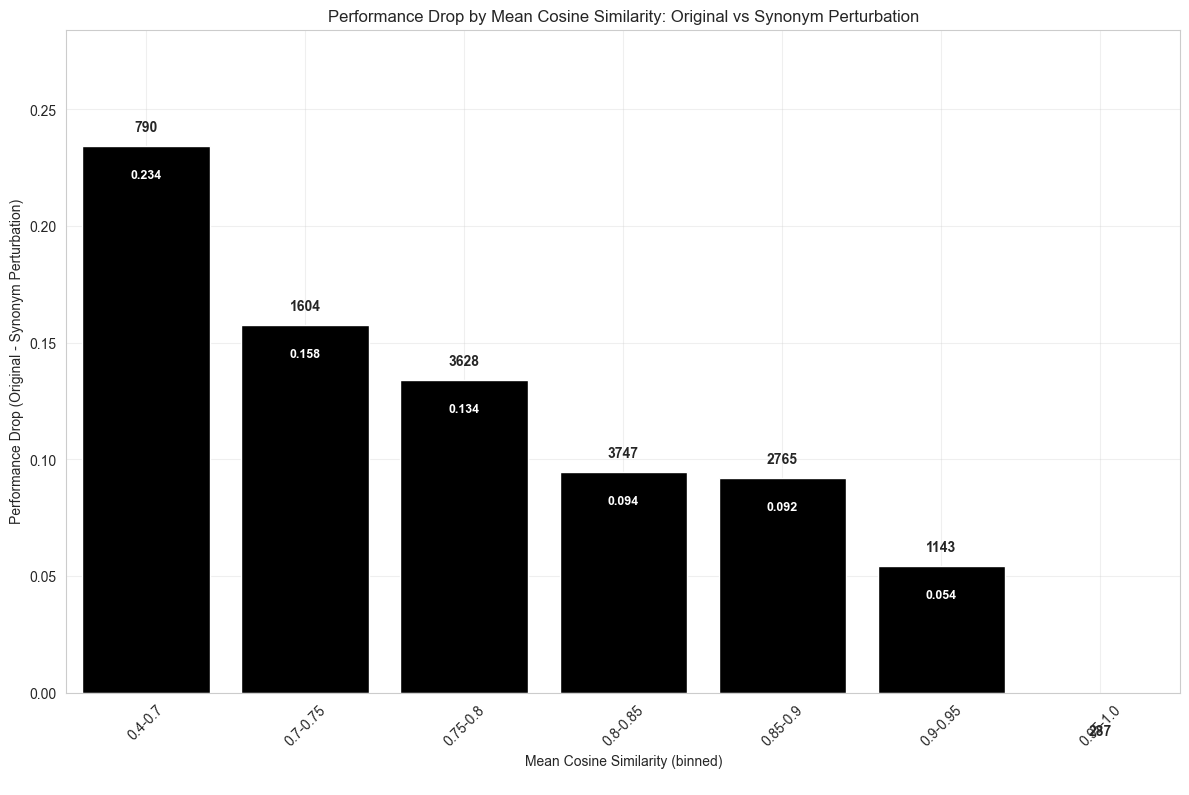

=== PERFORMANCE DROP BY COSINE SIMILARITY ANALYSIS ===
Overall performance drop: 0.106
Maximum performance drop: 0.234
Minimum performance drop: -0.024
Standard deviation: 0.082

Bin distribution:
cosine_bin
0.4-0.7      790
0.7-0.75    1604
0.75-0.8    3628
0.8-0.85    3747
0.85-0.9    2765
0.9-0.95    1143
0.95-1.0     287
Name: count, dtype: int64

Cosine similarity distribution:
count    14042.000000
mean         0.813399
std          0.070940
min          0.434014
25%          0.768723
50%          0.811901
75%          0.862524
max          1.000000
Name: mean_cosine_similarity, dtype: float64


In [71]:
# Create bins for mean_cosine_similarity based on actual data distribution
# Using quantile-based bins for better distribution
cosine_bins = [0.4, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
cosine_labels = ['0.4-0.7', '0.7-0.75', '0.75-0.8', '0.8-0.85', '0.85-0.9', '0.9-0.95', '0.95-1.0']

synonym_preds_df['cosine_bin'] = pd.cut(
    synonym_preds_df['mean_cosine_similarity'],
    bins=cosine_bins,
    labels=cosine_labels,
    right=False
)

# Calculate accuracy per bin for both original and perturbed data
cosine_bin_accuracy_original = synonym_preds_df.groupby('cosine_bin', observed=False)['correct_original_prediction'].mean().reset_index()
cosine_bin_accuracy_perturbed = synonym_preds_df.groupby('cosine_bin', observed=False)['correct_prediction'].mean().reset_index()

# Calculate performance drop (original - perturbed) for each bin
cosine_bin_accuracy_original['performance_drop'] = cosine_bin_accuracy_original['correct_original_prediction'] - cosine_bin_accuracy_perturbed['correct_prediction']

# Calculate counts per bin
cosine_bin_counts = synonym_preds_df['cosine_bin'].value_counts().reindex(cosine_labels)

# Filter out NaN values for plotting
valid_data = cosine_bin_accuracy_original.dropna(subset=['performance_drop'])

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='cosine_bin', y='performance_drop', data=valid_data, color='black')

# Annotate counts on top of bars
for i, (label, count) in enumerate(zip(cosine_labels, cosine_bin_counts)):
    if not pd.isna(count) and count > 0:
        # Find the corresponding y value for this label
        y_val = valid_data[valid_data['cosine_bin'] == label]['performance_drop'].iloc[0] if len(valid_data[valid_data['cosine_bin'] == label]) > 0 else 0
        ax.text(i, y_val + 0.005, str(int(count)), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add performance drop values on bars
for i, row in valid_data.iterrows():
    drop = row['performance_drop']
    if not pd.isna(drop):
        bin_idx = cosine_labels.index(row['cosine_bin'])
        ax.text(bin_idx, drop - 0.01, f'{drop:.3f}', 
                ha='center', va='top', fontsize=9, fontweight='bold', color='white')

plt.xlabel('Mean Cosine Similarity (binned)')
plt.ylabel('Performance Drop (Original - Synonym Perturbation)')
plt.title('Performance Drop by Mean Cosine Similarity: Original vs Synonym Perturbation')

# Set y-limits safely
valid_drops = valid_data['performance_drop'].dropna()
if len(valid_drops) > 0:
    plt.ylim(0, max(valid_drops) + 0.05)
else:
    plt.ylim(0, 0.2)

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
valid_drops = cosine_bin_accuracy_original['performance_drop'].dropna()
print("=== PERFORMANCE DROP BY COSINE SIMILARITY ANALYSIS ===")
if len(valid_drops) > 0:
    print(f"Overall performance drop: {valid_drops.mean():.3f}")
    print(f"Maximum performance drop: {valid_drops.max():.3f}")
    print(f"Minimum performance drop: {valid_drops.min():.3f}")
    print(f"Standard deviation: {valid_drops.std():.3f}")
else:
    print("No valid performance drop data found.")

# Show bin distribution
print(f"\nBin distribution:")
print(cosine_bin_counts.dropna())

# Show the distribution of cosine similarity values
print(f"\nCosine similarity distribution:")
print(synonym_preds_df['mean_cosine_similarity'].describe())
